In [1]:
# install and import all libraries required
# !c:\users\manavi\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip
# !pip install pandas
# !pip install numpy
# !pip install haversine
# !pip install matplotlib
# !pip install seaborn
# !pip install sklearn
# !pip install imblearn
# !pip install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.ticker as mtick
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [2]:
# load datasets
fraudtrain = pd.read_csv("./fraudTrain.csv")
fraudtest = pd.read_csv("./fraudTest.csv")

fraudtest.drop('Unnamed: 0', axis=1, inplace=True)
fraudtrain.drop('Unnamed: 0', axis=1, inplace=True)

# concanate both 
data_train = pd.concat([fraudtrain,fraudtest])

In [3]:
data_train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
def dataset_overview(data_train):
    variables = data_train.shape[1]
    observations = data_train.shape[0]
    missings = data_train.isnull().sum().sum()
    duplicated = data_train.duplicated().sum()
    categ = len(data_train.select_dtypes(include=[np.number]).columns.values)
    numer = len(data_train.select_dtypes(exclude=[np.number]).columns.values)
    #names = ['Variables', 'Observations', 'Missings cells', 'Missing cells(%)','Duplicated rows','Duplicated rows(%)','Num cols','Categ cols']
    stats = list([variables, observations, missings,duplicated, categ, numer])
    over_df = pd.DataFrame({'General Overview':['Variables', 'Observations', 'Missings cells','Duplicated rows','Num cols','Categ cols'],
                           '': stats})
    over_df = over_df.set_index('General Overview')
    print(over_df)
    display(data_train.dtypes)
    print('This train data set doesn\'t have null or duplicate values, All features and target have 1296675.')

dataset_overview(data_train)

                         
General Overview         
Variables              22
Observations      1852394
Missings cells          0
Duplicated rows         0
Num cols               10
Categ cols             12


trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

This train data set doesn't have null or duplicate values, All features and target have 1296675.


In [5]:
## feature engineering

# create distance column from lat long and merchant adress
# sometimes distance from the customer's home location to the merchant's location can prove out to be main reason for fraud, 
# so taking the displacement
def calculate_Distance(row):
    distance = haversine((row['merch_lat'], row['merch_long']), (row['lat'], row['long']), unit=Unit.MILES)
    return distance
data_train['Distance'] = data_train.apply(lambda row: calculate_Distance(row), axis = 1)

# clean date of DOB and trans_date_trans_time
dates_list = ['trans_date_trans_time','dob']
for x in dates_list:
    data_train[x] = pd.to_datetime(data_train[x])

# get hours from the transaction
# Although date part in column trans_date_trans_time is not important because that is historical data, 
# but time part of the component is important
# so creating a column of time
data_train['trans_hour'] = data_train['trans_date_trans_time'].dt.hour

# days when the transaction occured 
data_train['day_of_week'] = data_train['trans_date_trans_time'].dt.day_name()

# period when the transaction occured
data_train['year_month'] = data_train['trans_date_trans_time'].dt.to_period('M')

# the age of the client when the transaction occured
data_train['age'] = (np.round((data_train['trans_date_trans_time'] - data_train['dob'])/np.timedelta64(1,'Y')))

# get the full name 
data_train['names'] = data_train['first'] + ' ' + data_train['last']
data_train.drop(['first','last'], axis=1, inplace=True)

# create the column where the if the population is less than 25% to be rural, 25-50% ssemi-urban, and more than 50% urban
data_train['residence'] = pd.qcut(data_train.city_pop, q=[0, .25, .75, 1], labels=['rural', 'semi_urban', 'urban'])



In [6]:
data_train.drop(columns = ['dob', 'merch_lat', 'merch_long', 'lat', 'long', 'city_pop', 'city', 'job', 'state'], inplace = True)
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 555718
Data columns (total 18 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   merchant               object        
 3   category               object        
 4   amt                    float64       
 5   gender                 object        
 6   street                 object        
 7   zip                    int64         
 8   trans_num              object        
 9   unix_time              int64         
 10  is_fraud               int64         
 11  Distance               float64       
 12  trans_hour             int64         
 13  day_of_week            object        
 14  year_month             period[M]     
 15  age                    float64       
 16  names                  object        
 17  residence              category      
dtypes: category(1), datetim

<AxesSubplot:title={'center':'Number of frauds by category'}, xlabel='category', ylabel='is_fraud'>

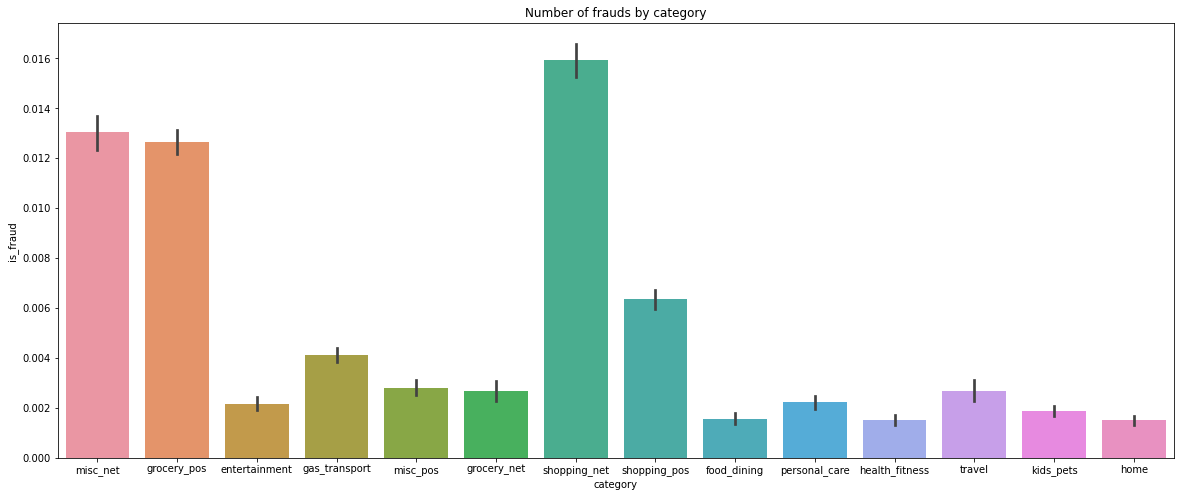

In [7]:
## Exploratory Data Analysis - Understanding the data better
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.title('Number of frauds by category')
sns.barplot(x="category", y='is_fraud' ,data=data_train)

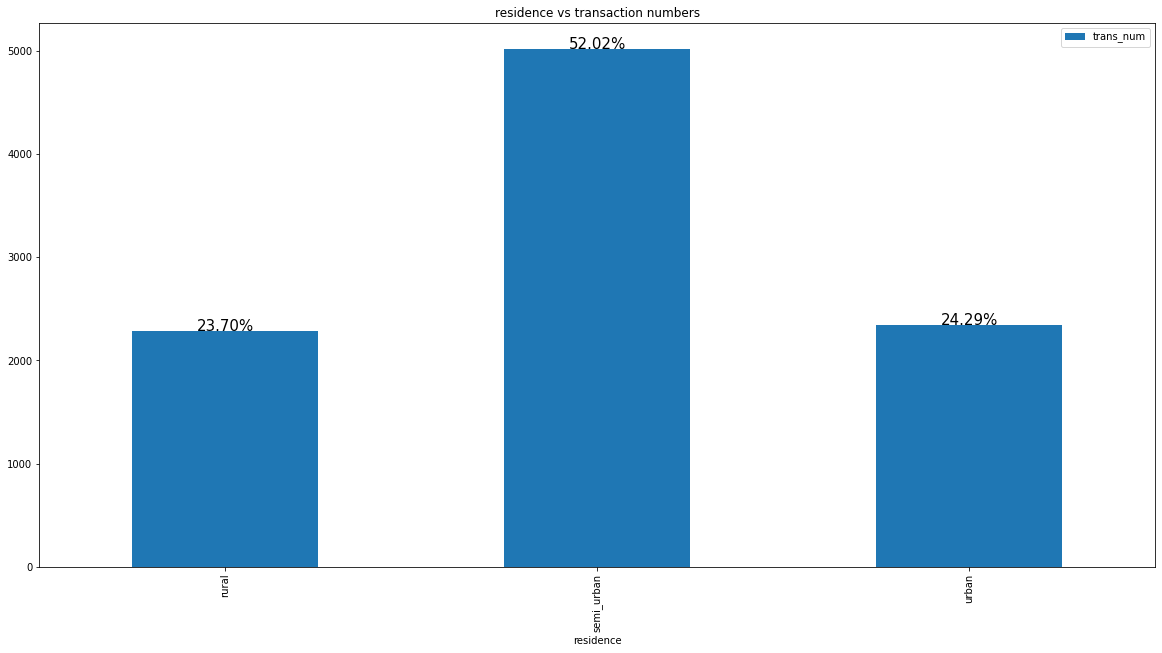

In [8]:
fraud = data_train[(data_train['is_fraud']==1)] 
ax = fraud.groupby(fraud['residence'])['trans_num'].nunique().reset_index().set_index('residence').plot.bar(figsize=(20,10))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(fraud)*100),
            ha="center", fontsize=15)
ax.set_title('residence vs transaction numbers')
plt.show()

<AxesSubplot:title={'center':'Number of frauds by gender'}, xlabel='gender', ylabel='is_fraud'>

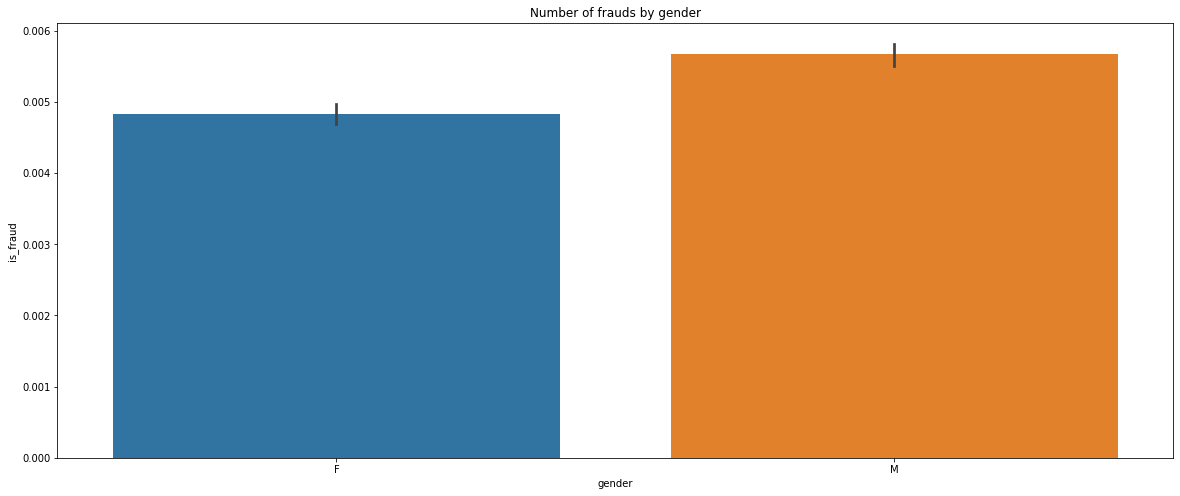

In [9]:
plt.figure(figsize=(20,8))
plt.title('Number of frauds by gender')
sns.barplot(x="gender", y='is_fraud' ,data=data_train)

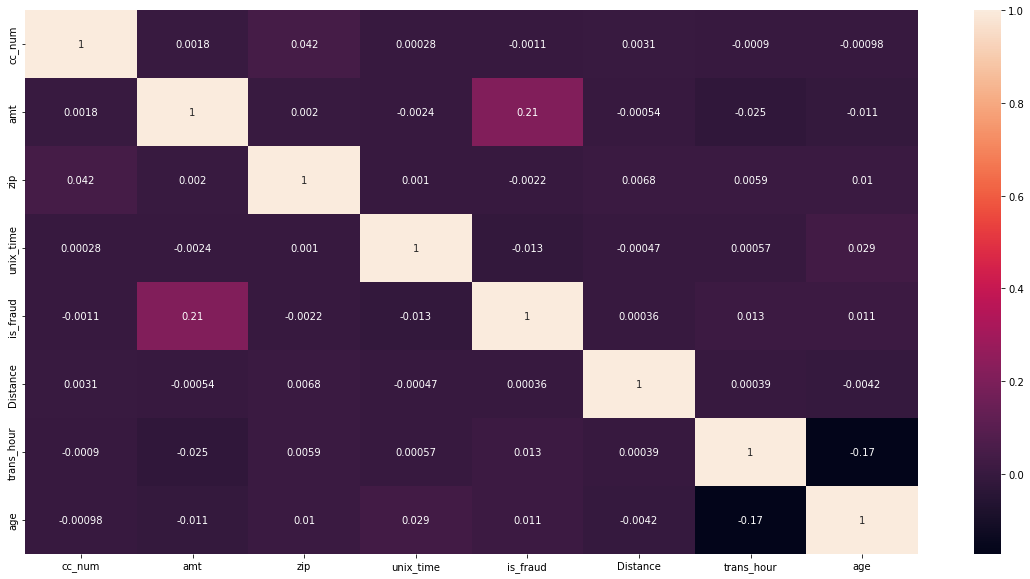

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(data_train.corr(), annot=True)
plt.show()

In [11]:
print("Number of is_fraud data",data_train['is_fraud'].value_counts())

Number of is_fraud data 0    1842743
1       9651
Name: is_fraud, dtype: int64


In [12]:
categ = len(data_train.select_dtypes(include=[np.number]).columns.values)
print(categ)

dframe = data_train.copy()
dframe = dframe.drop(['cc_num','trans_date_trans_time','names', 'merchant','trans_num','street', 'zip','year_month'],axis=1)
# creating a dummy variable for ome of the categoorical variables and drop the first ones
dummy_var1 = pd.get_dummies(dframe[['category', 'day_of_week', 'gender', 'residence']], drop_first= True)
# adding the resultss to the master dataframe
dframe = pd.concat([dframe, dummy_var1], axis=1)
#dropping the repeated variables
dframe = dframe.drop(columns=['category', 'day_of_week', 'gender', 'residence'],axis=1)
dframe.info()

8
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 555718
Data columns (total 28 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amt                      float64
 1   unix_time                int64  
 2   is_fraud                 int64  
 3   Distance                 float64
 4   trans_hour               int64  
 5   age                      float64
 6   category_food_dining     uint8  
 7   category_gas_transport   uint8  
 8   category_grocery_net     uint8  
 9   category_grocery_pos     uint8  
 10  category_health_fitness  uint8  
 11  category_home            uint8  
 12  category_kids_pets       uint8  
 13  category_misc_net        uint8  
 14  category_misc_pos        uint8  
 15  category_personal_care   uint8  
 16  category_shopping_net    uint8  
 17  category_shopping_pos    uint8  
 18  category_travel          uint8  
 19  day_of_week_Monday       uint8  
 20  day_of_week_Saturday     uint8  
 21  day_of_

In [13]:
from sklearn.preprocessing import RobustScaler
# select columns to scale 
to_scale = [col for col in dframe.columns if dframe[col].max()>1]
scaler = RobustScaler()
scaled =scaler.fit_transform(dframe[to_scale])
scaled = pd.DataFrame(scaled, columns=to_scale)

# replace original columns with scaled columns
for col in scaled:
    dframe[col] = scaled[col]
#make a copy of this dataframe
df = dframe.copy()

In [14]:
# Apply smote from https://www.kaggle.com/code/cedricmutoni/credit-card-fraud-detection/notebook#Data-Preparation
# from sklearn.model_selection import train_test_split
X = df.drop(['is_fraud'],axis=1) 
y = df['is_fraud'] #target variable
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=42)

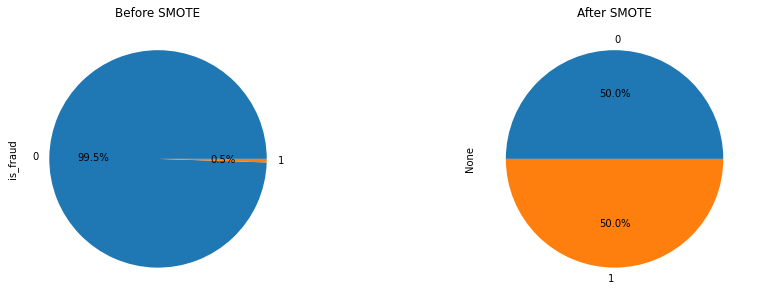

In [15]:
from imblearn.over_sampling import SMOTE
import matplotlib.ticker as mtick
smote = SMOTE()
X_train_new, y_train_new = smote.fit_resample(X_train, y_train.ravel())

# to demonstrate the effect of SMOTE over imbalanced datasets
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before SMOTE')
pd.Series(y_train).value_counts().plot.pie(autopct='%.1f%%',ax=ax1)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.set_title('After SMOTE')  
pd.Series(y_train_new).value_counts().plot.pie(autopct='%.1f%%',ax=ax2)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

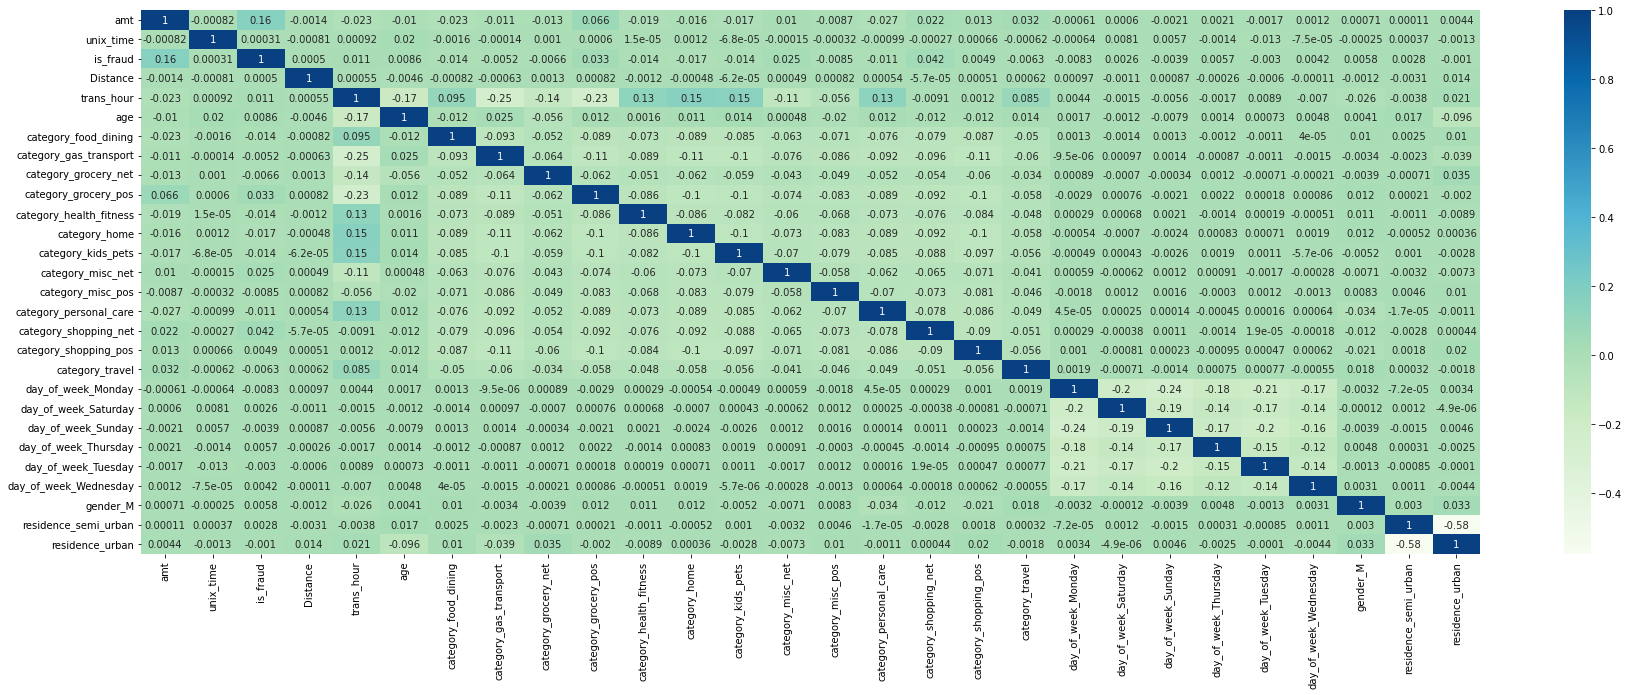

In [16]:
# let's see the correlation matrix
plt.figure(figsize= (30, 10))
sns.heatmap(df.corr(), annot=True, cmap= 'GnBu')
plt.show()

## LOGISTIC REGRESSION

In [17]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_new, y_train_new)
y_test_pred = logreg.predict(X_test)

print('Accuracy score of Logistic Regression is {}'.format(accuracy_score(y_test, y_test_pred)))
print('F1 score of Logistic Regression is {}'.format(f1_score(y_test, y_test_pred)))

print(confusion_matrix(y_test,y_test_pred))
# print('\n')
# print(classification_report(y_test,y_test_pred))

Accuracy score of Logistic Regression is 0.840417549157038
F1 score of Logistic Regression is 0.042289873540750984
[[465078  87703]
 [   980   1958]]


## DECISION TREE

In [18]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
dtree_pred = dtree.predict(X_test)

print('Accuracy score of Decision Tree model is {}'.format(accuracy_score(y_test, dtree_pred)))
print('F1 score of Decision Tree model is {}'.format(f1_score(y_test, dtree_pred)))

print(confusion_matrix(y_test,dtree_pred))
# print('\n')
# print(classification_report(y_test,dtree_pred))

Accuracy score of Decision Tree model is 0.9951990124505371
F1 score of Decision Tree model is 0.5545909849749583
[[551390   1391]
 [  1277   1661]]


## RANDOM FOREST

In [19]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)

print('Accuracy score of Random Forest model is {}'.format(accuracy_score(y_test, rfc_pred)))
print('F1 score of Random Forest model is {}'.format(f1_score(y_test, rfc_pred)))

print(confusion_matrix(y_test,rfc_pred))
# print('\n')
# print(classification_report(y_test,rfc_pred))

Accuracy score of Random Forest model is 0.9971784301058628
F1 score of Random Forest model is 0.6561403508771929
[[552655    126]
 [  1442   1496]]


## XGBOOST

In [20]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth = 4, use_label_encoder=False)
xgb.fit(X_train, y_train)
xgb_yhat = xgb.predict(X_test)

print('Accuracy score of the XGBoost model is {}'.format(accuracy_score(y_test, xgb_yhat)))
print('F1 score of the XGBoost model is {}'.format(f1_score(y_test, xgb_yhat)))

print(confusion_matrix(y_test,xgb_yhat))
# print('\n')
# print(classification_report(y_test,xgb_yhat))

C:\Users\97455\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\97455\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[22:47:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score of the XGBoost model is 0.997169432752884
F1 score of the XGBoost model is 0.6636732948471241
[[552594    187]
 [  1386   1552]]
